In [1]:
import torch

import triton
import triton.language as tl
from triton.tools.mxfp import MXFP4Tensor

DEVICE = triton.runtime.driver.active.get_active_torch_device()


@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE': 512}, num_warps=4, num_stages=3),
        triton.Config({'BLOCK_SIZE': 2048}, num_warps=4, num_stages=3),
    ],
    key=['n_elements'],
)
@triton.jit
def quantize_to_fp4_kernel(
        x_ptr,
        candidates_ptr,
        output_ptr,
        n_elements,
        BLOCK_SIZE: tl.constexpr,
    ):
    pid = tl.program_id(axis=0)
    x_block_start = pid * BLOCK_SIZE

    # i -- индекс пары внутри блока (каждая пара = 2 входных элемента -> 1 байт)
    i = tl.arange(0, BLOCK_SIZE // 2)

    even_idx = x_block_start + 2 * i    # глобальные индексы чётных элементов блока
    odd_idx  = even_idx + 1             # глобальные индексы нечётных

    # маски существования элементов (вне блока могут быть выходы за n_elements)
    mask_even = even_idx < n_elements
    mask_odd  = odd_idx  < n_elements

    # загружаем по одной выборке: чётные и нечётные
    x_even = tl.load(x_ptr + even_idx, mask=mask_even).to(tl.float32)
    x_odd  = tl.load(x_ptr + odd_idx,  mask=mask_odd).to(tl.float32)

    candidates = tl.load(candidates_ptr + tl.arange(0, 8)).to(tl.float32)

    # вычисляем наилучший кандидат для каждого поднабора
    errors_even = (x_even.abs()[:, None] - candidates[None, :]).abs().to(tl.float32)
    bit_args_even = errors_even.argmin(axis=1, tie_break_left=True)

    errors_odd = (x_odd.abs()[:, None] - candidates[None, :]).abs().to(tl.float32)
    bit_args_odd = errors_odd.argmin(axis=1, tie_break_left=True)

    # S, E, M -> nibble (4 бита) для каждого
    S_even = tl.where(x_even >= 0, 0, 1).to(tl.uint8)
    E_even = (bit_args_even % 4).to(tl.uint8)
    M_even = (bit_args_even // 4).to(tl.uint8)
    nibble_even = (S_even << 3) | (E_even << 1) | M_even

    S_odd = tl.where(x_odd >= 0, 0, 1).to(tl.uint8)
    E_odd = (bit_args_odd % 4).to(tl.uint8)
    M_odd = (bit_args_odd // 4).to(tl.uint8)
    nibble_odd = (S_odd << 3) | (E_odd << 1) | M_odd

    # если нечётного элемента нет (mask_odd == False) — подставляем 0
    nibble_odd = tl.where(mask_odd, nibble_odd, 0)

    # упакуем: even -> старший ниббл, odd -> младший
    packed = (nibble_even << 4) | nibble_odd  # shape = BLOCK_SIZE // 2, dtype uint8

    # вычисляем оффсеты для записи
    out_block_start = (pid * BLOCK_SIZE) // 2
    out_offsets = out_block_start + i

    # записываем байты — пишем, если существует even элемент (иначе пары нет)
    out_store_mask = mask_even  # гарантирует, что хотя бы even существует
    tl.store(output_ptr + out_offsets, packed, mask=out_store_mask)


def quantize_to_fp4(x: torch.Tensor):
    assert x.is_contiguous()
    quantized_shape = (x.shape[0], x.shape[1] // 2)
    output = torch.empty(quantized_shape, dtype=torch.uint8, device=x.device)
    n_elements = x.numel()
    grid = lambda META: (triton.cdiv(n_elements, META['BLOCK_SIZE']),)

    candidates = torch.tensor([0.0000, 1.0000, 2.0000, 4.0000, 0.5000, 1.5000, 3.0000, 6.0000]).to(x.device)
    quantize_to_fp4_kernel[grid](x, candidates, output, n_elements)
    return output

In [2]:
import torch
import triton
from kernel_round_fp4 import round_to_fp4
from triton.tools.mxfp import MXFP4Tensor

In [3]:
# from triton.tools.mxfp import MXFP4Tensor

# x = torch.randn(2048, 2048, device="cuda") 
# # x = torch.tensor([0.25, 0.3, -0.3, 0.75, 1.25, 1.5, 2.5, 3.5, 5.0, 5.1, 7.0, -70]).cuda()
# # print(x)

# q1 = round_to_fp4(x)
# q2 = MXFP4Tensor(size=x.shape, data=x).data

# print(round_to_fp4_kernel.best_config)

# # _q1 = MXFP4Tensor(size=x.shape, device=x.device)
# # _q1.data = q1

# # q2.to(torch.float32), q1.to(torch.float32)


In [4]:
### TEST ###

# print(torch.all(q1 == q2))

# diff_mask = q1 != q2
# indices = torch.nonzero(diff_mask, as_tuple=False)

# for idx in indices:
#     idx_tuple = tuple(idx.tolist())
#     print(f"{x[idx_tuple[0], idx_tuple[1]]}: q1={q1[idx_tuple].item()}, q2={q2[idx_tuple].item()}")

Quantization time, ms:
        N     kernel       matmul   quantize
0   512.0   0.215968     0.168064   0.297984
1  1024.0   0.364480     0.855584   0.359952
2  2048.0   0.944464     8.383696   0.846816
3  4096.0   2.774464    90.944893   2.834208
4  8192.0  10.653344  2328.379395  11.753472


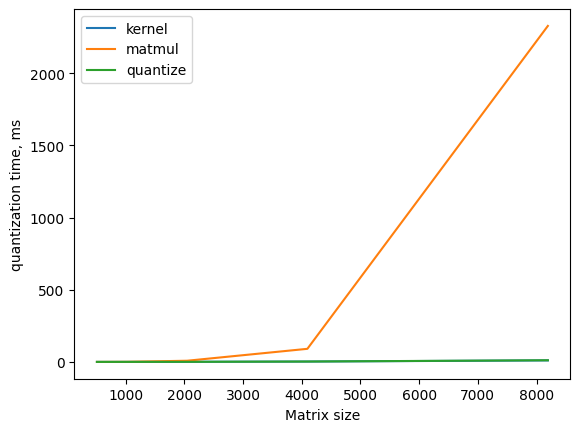

In [5]:
configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["N"],  # Argument names to use as an x-axis for the plot
        x_vals=[512, 1024, 2048, 4096, 8192],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        line_vals=[
            # "torch",
            "kernel",
            "matmul",
            "quantize"
            ],
        line_names=[
            # "torch",
            "kernel",
            "matmul",
            "quantize" 
            ],
        ylabel="quantization time, ms",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="Quantization time, ms",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))


### BENCHMARK ###
@triton.testing.perf_report(configs)
def benchmark(N, provider):
    x = 2 * torch.randn(N, N, dtype=torch.float32, device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: MXFP4Tensor(size=x.shape, data=x), quantiles=quantiles)
    if provider == "matmul":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x @ x, quantiles=quantiles)
    if provider == "kernel":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: round_to_fp4(x), quantiles=quantiles)
    if provider == "quantize":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: quantize_to_fp4(x), quantiles=quantiles)

    return ms, max_ms, min_ms

bench_data = benchmark.run(show_plots=False, print_data=True, return_df=True)

KeyError: 'torch'

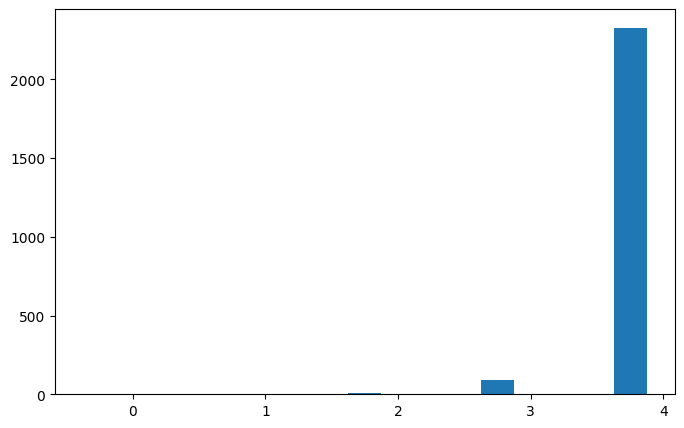

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(bench_data[0])

plt.figure(figsize=(8, 5))
width = 0.25
x = range(len(df))

plt.bar([i - width for i in x], df["matmul"], width=width, label="matmul")
plt.bar(x, df["torch"], width=width, label="quantization (torch)")
plt.bar([i + width for i in x], df["kernel"], width=width, label="quantization (kernel)")

plt.xticks(x, df["N"], fontsize=12)
plt.xlabel("Matrix size", fontsize=14)
plt.ylabel("Time, ms", fontsize=14)
plt.title("Quantization time VS matmul time", fontsize=16, pad=10)
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()